In [12]:
!pip install scikit-surprise
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import gzip
from surprise import accuracy, Dataset, KNNBasic, Reader
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

In [14]:
csv = pd.read_csv('https://raw.githubusercontent.com/MengtingWan/marketBias/master/data/df_modcloth.csv')
df = pd.DataFrame(csv)
print(df)
print(df.isnull().sum())
print(df['item_id'].nunique())

       item_id       user_id  rating                         timestamp  size  \
0         7443          Alex       4         2010-01-21 08:00:00+00:00   NaN   
1         7443  carolyn.agan       3         2010-01-27 08:00:00+00:00   NaN   
2         7443         Robyn       4         2010-01-29 08:00:00+00:00   NaN   
3         7443            De       4         2010-02-13 08:00:00+00:00   NaN   
4         7443         tasha       4         2010-02-18 08:00:00+00:00   NaN   
...        ...           ...     ...                               ...   ...   
99888   154797     BernMarie       5  2019-06-26 21:15:13.165000+00:00   6.0   
99889    77949           Sam       4  2019-06-26 23:22:29.633000+00:00   4.0   
99890    67194        Janice       5  2019-06-27 00:20:52.125000+00:00   NaN   
99891    71607           amy       3  2019-06-27 15:45:06.250000+00:00   NaN   
99892   119732         sarah       3  2019-06-29 13:55:16.542000+00:00   NaN   

                  fit user_attr   model

CATEGORICAL LABEL INTO NUMBERS

In [15]:
df_ready = df.dropna()
df_ready.reset_index(drop=True, inplace=True)
le = LabelEncoder()

df_ready['user_attr_e'] = le.fit_transform(df_ready['user_attr'])
df_ready['user_id_e'] = le.fit_transform(df_ready['user_id'])
df_ready['fit_e'] = le.fit_transform(df_ready['fit'])
df_ready['model_attr_e'] = le.fit_transform(df_ready['model_attr'])
df_ready['category_e'] = le.fit_transform(df_ready['category'])
df_ready['brand_e'] = le.fit_transform(df_ready['brand'])
df_ready['timestamp_e'] = le.fit_transform(df_ready['timestamp'])

df_ready = df_ready.drop(columns=['user_attr', 'fit', 'model_attr', 'category','brand','user_id', 'timestamp'], axis=1)

print(df_ready)


       item_id  rating  size  year  split  user_attr_e  user_id_e  fit_e  \
0        21296       5   3.0  2013      0            1       1703      0   
1        21296       5   1.0  2013      0            0       4648      0   
2        21296       5   2.0  2013      0            1       1945      0   
3        21296       4   1.0  2013      0            1       6321      0   
4        21296       4   1.0  2013      0            1       7255      0   
...        ...     ...   ...   ...    ...          ...        ...    ...   
15425   147244       5   5.0  2016      2            1       2050      0   
15426     6454       2   3.0  2017      0            1        720      1   
15427    70538       5   6.0  2017      0            0       1074      0   
15428   119314       1   2.0  2017      0            1        605      0   
15429    86073       3   7.0  2017      0            0        747      2   

       model_attr_e  category_e  brand_e  timestamp_e  
0                 0           0

<ipython-input-15-cd68cf91a9fb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ready['user_attr_e'] = le.fit_transform(df_ready['user_attr'])
<ipython-input-15-cd68cf91a9fb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ready['user_id_e'] = le.fit_transform(df_ready['user_id'])
<ipython-input-15-cd68cf91a9fb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

ANALISI ESPLORATIVA

In [ ]:
df_ready.describe()

,item_id,rating,size,year,split,user_attr_e,user_id_e,fit_e,model_attr_e,category_e,brand_e,timestamp_e
count,15430.000000,15430.000000,15430.000000,15430.000000,15430.000000,15430.000000,15430.000000,15430.000000,15430.000000,15430.000000,15430.000000,15430.000000
mean,85924.922035,4.308749,3.276993,2015.539339,0.354893,0.773558,4582.564874,0.665262,0.567725,1.456124,17.442126,1357.225340
std,45123.696724,1.011218,1.901252,1.891229,0.719379,0.418542,3299.707807,1.024683,0.495408,1.085728,6.411383,521.563703
min,6454.000000,1.000000,0.000000,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54222.000000,4.000000,2.000000,2014.000000,0.000000,1.000000,1530.000000,0.000000,0.000000,1.000000,19.000000,1004.000000
50%,70538.000000,5.000000,3.000000,2016.000000,0.000000,1.000000,4129.500000,0.000000,1.000000,1.000000,19.000000,1386.000000
75%,128563.000000,5.000000,5.000000,2017.000000,0.000000,1.000000,7457.750000,1.000000,1.000000,3.000000,19.000000,1717.000000
max,155597.000000,5.000000,8.000000,2019.000000,2.000000,1.000000,10859.000000,4.000000,1.000000,3.000000,30.000000,2792.000000


((array([-4.34578659, -4.14700058, -4.03887895, ...,  4.03887895,
          4.14700058,  4.34578659]), array([1, 1, 1, ..., 5, 5, 5])),
 (0.9277851929156878, 4.209594265864475, 0.8585234852101923))

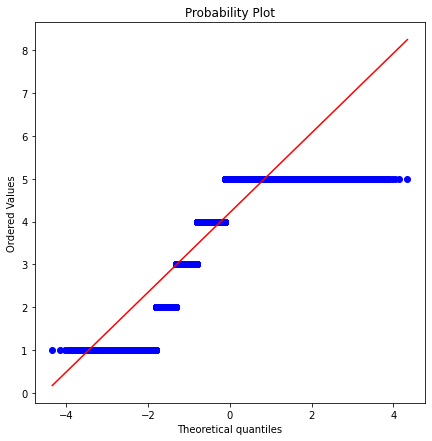

In [ ]:
from scipy import stats
plt.figure(figsize=(7,7))
stats.probplot(df['rating'], dist='norm', plot=plt)

In [ ]:
df.groupby('year').rating.value_counts().unstack()

rating,1,2,3,4,5
year,,,,,
2010,28,67,128,256,375
2011,101,151,218,385,405
2012,126,214,450,935,1387
2013,289,570,1258,3305,8855
2014,456,771,1466,3102,6222
2015,599,987,2023,4444,9328
2016,617,1073,2221,4545,9913
2017,483,740,1357,2927,7403
2018,664,1033,1844,3861,8828


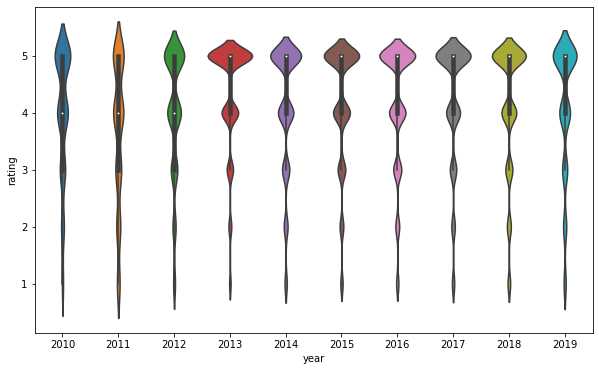

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.violinplot(data=df, x="year", y="rating")
plt.show()

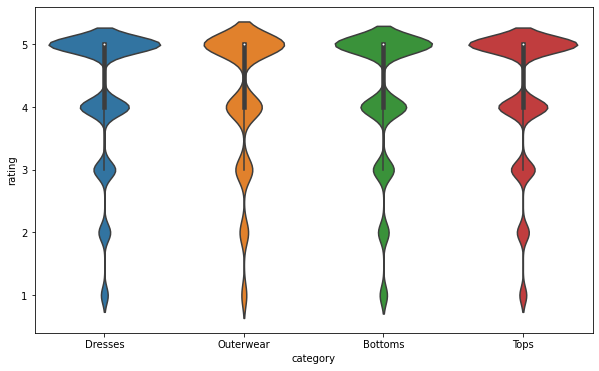

In [ ]:
plt.figure(figsize=(10,6))
sns.violinplot(data=df, x="category", y="rating")
plt.show()

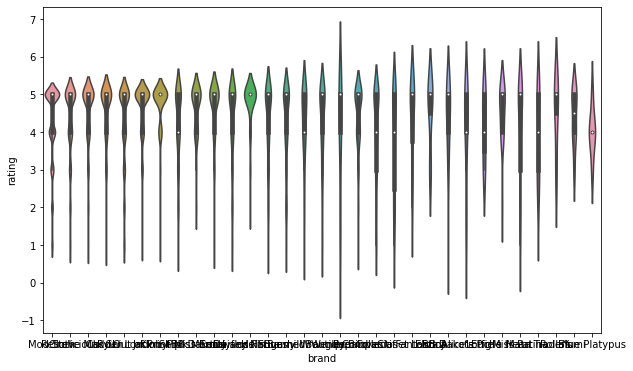

In [ ]:
plt.figure(figsize=(10,6))
sns.violinplot(data=df, x="brand", y="rating")
plt.show()

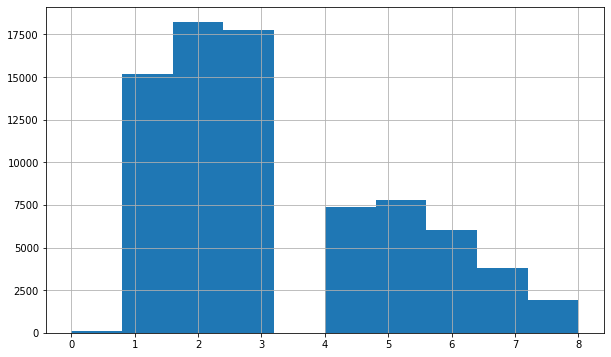

In [ ]:
plt.figure(figsize=(10,6))
df['size'].hist()
plt.show()

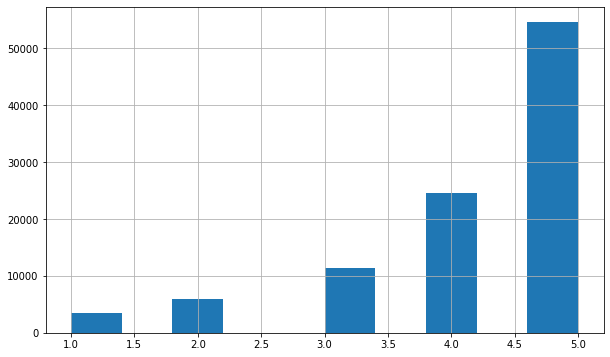

In [ ]:
plt.figure(figsize=(10,6))
df['rating'].hist()
plt.show()

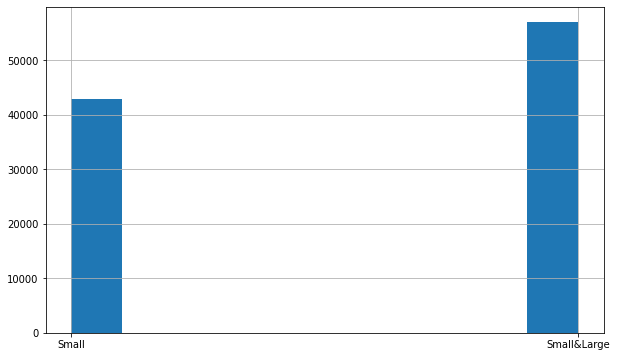

In [ ]:
plt.figure(figsize=(10,6))
df['model_attr'].hist()
plt.show()

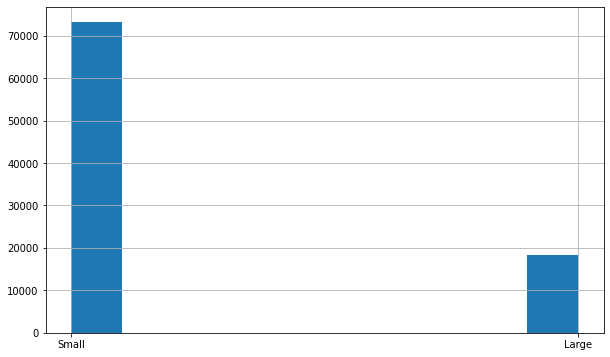

In [ ]:
plt.figure(figsize=(10,6))
df['user_attr'].hist()
plt.show()

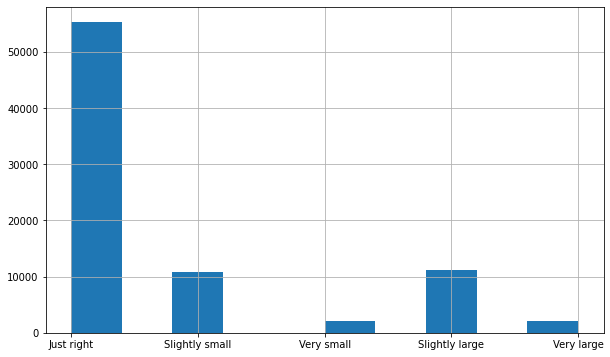

In [ ]:
plt.figure(figsize=(10,6))
df['fit'].hist()
plt.show()

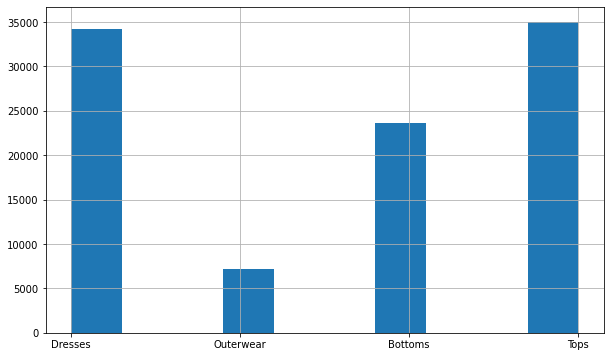

In [ ]:
plt.figure(figsize=(10,6))
df['category'].hist()
plt.show()

((array([-3.91650467, -3.69709995, -3.57690154, ...,  3.57690154,
          3.69709995,  3.91650467]), array([0, 0, 0, ..., 3, 3, 3])),
 (0.9976767473779281, 1.4561244329228773, 0.918708635041582))

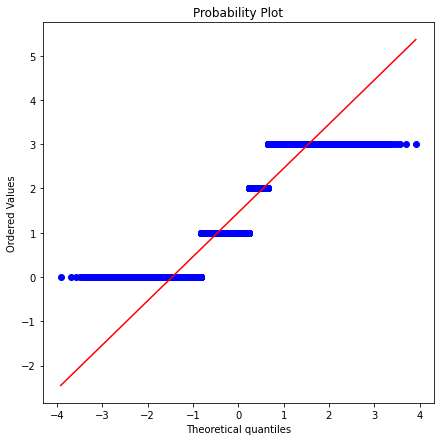

In [8]:
from scipy import stats
plt.figure(figsize=(7,7))
stats.probplot(df_ready['category_e'], dist='norm', plot=plt)

CORRELATION

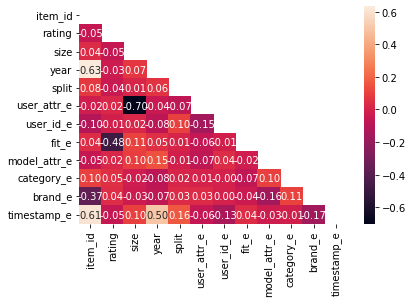

In [ ]:
df_corr = df_ready.corr()
sns.heatmap(df_corr, annot=True, fmt=".2f", mask=~np.tri(df_corr.shape[0], k=-1, dtype=bool), cbar=True)

In [18]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

df_corr_e = df.copy()

# Create an instance of OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the categorical columns
ohe.fit(df_corr_e[['fit', 'model_attr', 'user_attr']])

# Transform the categorical columns into one-hot encoded features
one_hot_features = ohe.transform(df_corr_e[['fit', 'model_attr', 'user_attr']]).toarray()

# Add the one-hot encoded features to the original dataframe
for i, col in enumerate(ohe.get_feature_names(['fit', 'model_attr', 'user_attr'])):
    df_corr_e[col] = one_hot_features[:, i]

# Print the updated dataframe
print(df_corr_e)

       item_id       user_id  rating                         timestamp  size  \
0         7443          Alex       4         2010-01-21 08:00:00+00:00   NaN   
1         7443  carolyn.agan       3         2010-01-27 08:00:00+00:00   NaN   
2         7443         Robyn       4         2010-01-29 08:00:00+00:00   NaN   
3         7443            De       4         2010-02-13 08:00:00+00:00   NaN   
4         7443         tasha       4         2010-02-18 08:00:00+00:00   NaN   
...        ...           ...     ...                               ...   ...   
99888   154797     BernMarie       5  2019-06-26 21:15:13.165000+00:00   6.0   
99889    77949           Sam       4  2019-06-26 23:22:29.633000+00:00   4.0   
99890    67194        Janice       5  2019-06-27 00:20:52.125000+00:00   NaN   
99891    71607           amy       3  2019-06-27 15:45:06.250000+00:00   NaN   
99892   119732         sarah       3  2019-06-29 13:55:16.542000+00:00   NaN   

                  fit user_attr   model

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
columns = ['user_attr_Small', 'fit_Just right']
correlation = df_corr_e[columns].corr()
print(correlation)

                 user_attr_Small  fit_Just right
user_attr_Small         1.000000        0.088612
fit_Just right          0.088612        1.000000


In [ ]:
columns = ['fit_Just right','rating']
correlation = df_corr_e[columns].corr()
print(correlation)

                fit_Just right    rating
fit_Just right        1.000000  0.323832
rating                0.323832  1.000000


In [ ]:
columns = ['fit_Just right','fit_Slightly large', 'fit_Slightly small','fit_Very large' ,'size']
correlation = df_corr_e[columns].corr()
print(correlation)

                    fit_Just right  fit_Slightly large  fit_Slightly small  \
fit_Just right            1.000000           -0.393908           -0.387035   
fit_Slightly large       -0.393908            1.000000           -0.123003   
fit_Slightly small       -0.387035           -0.123003            1.000000   
fit_Very large           -0.166173           -0.052811           -0.051890   
size                     -0.103351            0.045496            0.027023   

                    fit_Very large      size  
fit_Just right           -0.166173 -0.103351  
fit_Slightly large       -0.052811  0.045496  
fit_Slightly small       -0.051890  0.027023  
fit_Very large            1.000000  0.038473  
size                      0.038473  1.000000  


In [19]:
columns = ['user_attr_Small', 'user_attr_Large', 'size']
correlation = df_corr_e[columns].corr()
print(correlation)

                 user_attr_Small  user_attr_Large     size
user_attr_Small         1.000000        -0.785174 -0.69699
user_attr_Large        -0.785174         1.000000  0.69699
size                   -0.696990         0.696990  1.00000


In [20]:
columns = ['user_attr_Small', 'model_attr_Small&Large', 'rating']
correlation = df_corr_e[columns].corr()
print(correlation)

                        user_attr_Small  model_attr_Small&Large    rating
user_attr_Small                1.000000               -0.018680  0.027807
model_attr_Small&Large        -0.018680                1.000000  0.044797
rating                         0.027807                0.044797  1.000000


In [21]:
columns = ['user_attr_Small', 'user_attr_Large', 'model_attr_Small',  'model_attr_Small&Large']
correlation = df_corr_e[columns].corr()
print(correlation)

                        user_attr_Small  user_attr_Large  model_attr_Small  \
user_attr_Small                1.000000        -0.785174          0.018680   
user_attr_Large               -0.785174         1.000000         -0.043957   
model_attr_Small               0.018680        -0.043957          1.000000   
model_attr_Small&Large        -0.018680         0.043957         -1.000000   

                        model_attr_Small&Large  
user_attr_Small                      -0.018680  
user_attr_Large                       0.043957  
model_attr_Small                     -1.000000  
model_attr_Small&Large                1.000000  


Machine learning 

In [22]:
# Convert the pandas DataFrame into surprise dataset format
from surprise import Dataset
from surprise import Reader
reader = Reader(rating_scale=(1, 5))

In [23]:
data = Dataset.load_from_df(df_ready[['user_id_e', 'item_id', 'rating']], reader)

Elbow Method

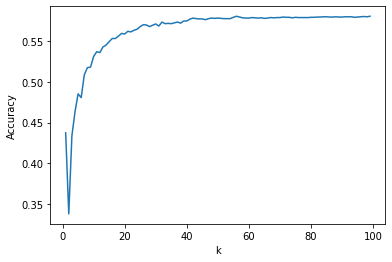

In [24]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Select Features
feature = df_ready.drop('rating', axis=1)
# Select Target
target = df_ready['rating']


def elbow_meth(feature, target):
    X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=1)
    
    scores = []
    for k in range(1, 100):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        score = knn.score(X_test, y_test)
        scores.append(score)
        
    plt.plot(range(1, 100), scores)
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.show()
    
elbow_meth(feature, target)

GRID SEARCH

In [25]:
# Define the grid of parameters (this depends on the algorithms)
param_grid = {
    'k': [10, 20, 30, 40, 50, 70, 80, 100],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [True, False],
    },
}
# Initialize and train the Grid Search
gs = GridSearchCV(KNNBasic, param_grid, measures=["rmse", "mse"], cv=5, n_jobs=1)
gs.fit(data)

# best RMSE score
print(f'Best RMSE = {gs.best_score["rmse"]:.4f}')
# combination of parameters that gave the best RMSE score
print(f'Best configuration = {gs.best_params["rmse"]}')

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing

ALGO KNN Rating

In [26]:
# Initialize the algorithm
from surprise.model_selection import train_test_split

sim_options = {
    "name": "cosine",
    "user_based": True,  # compute  similarities between items
}


algor = KNNBasic(k=70, sim_options=sim_options)
trainset, testset = train_test_split(data, test_size=0.2)

# Train and test the algorithm
algor.fit(trainset)
predictions = algor.test(testset)
# Compute metrics
mse = accuracy.mse(predictions)
rmse = accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
MSE: 1.0296
RMSE: 1.0147


Rating Matrix KNN

In [27]:
df_r = df.copy()
df_r.reset_index(drop=True, inplace=True)
le = LabelEncoder()

df_r['user_id_e'] = le.fit_transform(df_r['user_id'])

print(df_r['user_id_e'].nunique())
print(df_r['item_id'].nunique())

44784
1020


In [28]:
# Create a new dataframe for all combinations of user_id and item_id
import random
users = df_r['user_id_e'].unique()
users = random.sample(list(users), 447)
items = df_r['item_id'].unique()

# initialize the predictions dataframe
df_predictions = pd.DataFrame(columns=['user_id', 'item_id', 'rating'])

# Predict the ratings
for user in users:
    for item in items:
        pred = algor.predict(user, item)
        df_predictions = df_predictions.append({'user_id': user, 'item_id': item, 'rating': pred.est}, ignore_index=True)

# # Reset the index of the predictions dataframe
# df_predictions = predictions.reset_index(drop=True)

In [29]:
print(df_predictions)

        user_id   item_id   rating
0       27360.0    7443.0  4.31011
1       27360.0   11960.0  4.31011
2       27360.0   16411.0  4.31011
3       27360.0   21296.0  4.31011
4       27360.0   22563.0  4.31011
...         ...       ...      ...
455935  10537.0  153853.0  4.31011
455936  10537.0  153866.0  4.31011
455937  10537.0  149062.0  4.31011
455938  10537.0   54062.0  4.31011
455939  10537.0  153228.0  4.31011

[455940 rows x 3 columns]


Recomend Clothing

In [30]:
# Group by 'item_id' and calculate the mean rating for each item
grouped = df_predictions.groupby('item_id').agg({'rating': 'mean'})

# Reset the index and rename the 'rating' column to 'mean_rating'
grouped = grouped.reset_index().rename(columns={'rating': 'mean_rating'})

print(grouped)

       item_id  mean_rating
0       6454.0     4.361509
1       7443.0     4.310110
2      11960.0     4.310110
3      16411.0     4.310110
4      21296.0     4.301314
...        ...          ...
1015  155308.0     4.310110
1016  155317.0     4.310110
1017  155537.0     4.310110
1018  155597.0     4.307179
1019  155950.0     4.310110

[1020 rows x 2 columns]


In [31]:
# Create an empty list to store the recommendations for each user
recs = []

# Get a list of unique user IDs
user_ids = df['user_id'].unique()

# Loop through each user ID
for user_id in user_ids:
    # Get the ratings given by this user
    user_ratings = df[df['user_id'] == user_id][['item_id', 'rating']]
    
    # Get the items that the user has not rated
    unrated_items = grouped[~grouped['item_id'].isin(user_ratings['item_id'])]

    # Sort the unrated items by mean rating
    unrated_items = unrated_items.sort_values('mean_rating', ascending=False)

    # Keep only the top 10 items
    user_recs = unrated_items.head(10)
    
    # Add the recommendations for this user to the list of all recommendations
    recs.append((user_id, list(user_recs['item_id'])))
    
# Convert the list of recommendations to a DataFrame
recs_df = pd.DataFrame(recs, columns=['user_id', 'recommended_items'])

In [32]:
print(recs_df)

            user_id                                  recommended_items
0              Alex  [145278.0, 153106.0, 147870.0, 143764.0, 12127...
1      carolyn.agan  [145278.0, 153106.0, 147870.0, 143764.0, 12127...
2             Robyn  [145278.0, 153106.0, 147870.0, 143764.0, 12127...
3                De  [145278.0, 153106.0, 147870.0, 143764.0, 12127...
4             tasha  [145278.0, 153106.0, 147870.0, 143764.0, 12127...
...             ...                                                ...
44779         Marso  [145278.0, 153106.0, 147870.0, 143764.0, 12127...
44780      Foucault  [145278.0, 153106.0, 147870.0, 143764.0, 12127...
44781        nadgee  [145278.0, 153106.0, 147870.0, 143764.0, 12127...
44782      roshelle  [145278.0, 153106.0, 147870.0, 143764.0, 12127...
44783     BernMarie  [145278.0, 153106.0, 147870.0, 143764.0, 12127...

[44784 rows x 2 columns]


CLUSTERING

In [33]:
def jitter(values,j):
    return values + np.random.normal(j,0.1,values.shape)

In [34]:
df_means = df.copy()
le = LabelEncoder()

df_means['user_attr_e'] = le.fit_transform(df_means['user_attr'])
df_means['fit_e'] = le.fit_transform(df_means['fit'])
df_means['model_attr_e'] = le.fit_transform(df_means['model_attr'])
df_means['category_e'] = le.fit_transform(df_means['category'])
# df_means['brand_e'] = le.fit_transform(df_means['brand'])
# df_means['timestamp_e'] = le.fit_transform(df_means['timestamp'])
df_means['user_id_e'] = le.fit_transform(df_means['user_id'])

# # convert the values in col1 to integers
# df_means['size'] = pd.to_numeric(df_means['size'], errors='coerce').fillna(0).astype(int)
df_means = df_means.drop(columns=['user_attr', 'fit', 'model_attr', 'category','brand', 'timestamp', 'year','user_id'])

df_means = df_means.fillna(value=0)

# df_means = df_means.sample(n=50000, random_state=42)

df_means = df_means.reset_index(drop=True)


print(df_means)
print(df_means.isnull().sum())

       item_id  rating  size  split  user_attr_e  fit_e  model_attr_e  \
0         7443       4   0.0      0            1      5             0   
1         7443       3   0.0      0            2      5             0   
2         7443       4   0.0      0            1      5             0   
3         7443       4   0.0      0            2      5             0   
4         7443       4   0.0      0            1      5             0   
...        ...     ...   ...    ...          ...    ...           ...   
99888   154797       5   6.0      0            0      0             1   
99889    77949       4   4.0      2            1      2             1   
99890    67194       5   0.0      2            1      0             1   
99891    71607       3   0.0      2            1      2             1   
99892   119732       3   0.0      2            1      0             0   

       category_e  user_id_e  
0               1        309  
1               1      13009  
2               1       5534  

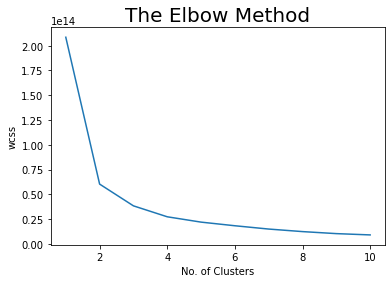

In [35]:
from sklearn.cluster import KMeans

wcss = []

for i in range(1, 11):

  km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
  km.fit(df_means)
  wcss.append(km.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()


DF_means skLearn

In [36]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

# fit KMeans to your data
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
labels = km.fit_predict(df_means)
df_means['label'] = labels

In [37]:
print(df_means)

       item_id  rating  size  split  user_attr_e  fit_e  model_attr_e  \
0         7443       4   0.0      0            1      5             0   
1         7443       3   0.0      0            2      5             0   
2         7443       4   0.0      0            1      5             0   
3         7443       4   0.0      0            2      5             0   
4         7443       4   0.0      0            1      5             0   
...        ...     ...   ...    ...          ...    ...           ...   
99888   154797       5   6.0      0            0      0             1   
99889    77949       4   4.0      2            1      2             1   
99890    67194       5   0.0      2            1      0             1   
99891    71607       3   0.0      2            1      2             1   
99892   119732       3   0.0      2            1      0             0   

       category_e  user_id_e  label  
0               1        309      2  
1               1      13009      2  
2        

In [38]:
from sklearn import metrics
silhouette_score = metrics.silhouette_score(df_means, df_means["label"])
print('Silhouette score =', silhouette_score)

Silhouette score = 0.4543180889817841


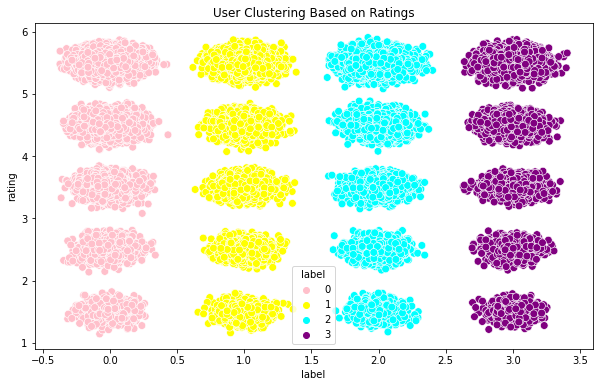

In [39]:
# visualize the clusters using a scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x = jitter(df_means.label,0), y = jitter(df_means.rating,0.5), hue="label", palette=['pink','yellow','cyan', 'purple'], legend='full', data = df_means, s = 60)
plt.xlabel('label')
plt.ylabel('rating')
plt.title('User Clustering Based on Ratings')
plt.show()

CLUSTERING 2

In [40]:
df_prediction2 = df_predictions.copy()

In [41]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

# fit KMeans to your data
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(df_prediction2)

# create a new column to store the cluster label
df_prediction2['label'] = y_means

In [42]:
print(df_prediction2)

        user_id   item_id   rating  label
0       27360.0    7443.0  4.31011      1
1       27360.0   11960.0  4.31011      1
2       27360.0   16411.0  4.31011      1
3       27360.0   21296.0  4.31011      1
4       27360.0   22563.0  4.31011      1
...         ...       ...      ...    ...
455935  10537.0  153853.0  4.31011      0
455936  10537.0  153866.0  4.31011      0
455937  10537.0  149062.0  4.31011      0
455938  10537.0   54062.0  4.31011      1
455939  10537.0  153228.0  4.31011      0

[455940 rows x 4 columns]


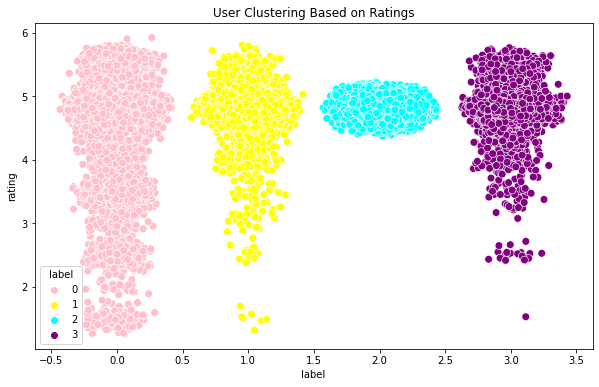

In [43]:
# visualize the clusters using a scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x = jitter(df_prediction2.label,0), y = jitter(df_prediction2.rating,0.5), hue="label", palette=['pink','yellow','cyan', 'purple'], legend='full', data = df_prediction2, s = 60)
plt.xlabel('label')
plt.ylabel('rating')
plt.title('User Clustering Based on Ratings')
plt.show()

In [ ]:
from sklearn import metrics
silhouette_score = metrics.silhouette_score(df_prediction2, df_prediction2["label"])
print('Silhouette score =', silhouette_score)

MATRIX FACTORIZATION SVD

In [ ]:
# Initialize the algorithm

from surprise import Dataset

data1 = Dataset.load_from_df(df_ready[['user_id_e', 'item_id', 'rating']], reader)

from surprise.model_selection import train_test_split
from surprise import SVD
# Define the SVD model
svd = SVD()


trainset, testset = train_test_split(data1, test_size=0.2)

# Train and test the algorithm
svd.fit(trainset)
predictionsmf = svd.test(testset)
# Compute metrics
mse = accuracy.mse(predictionsmf)
rmse = accuracy.rmse(predictionsmf)

RATING MATRIX SVD

In [ ]:
# initialize the predictions dataframe
df_predictionsSVD = pd.DataFrame(columns=['user_id', 'item_id', 'rating'])

# Predict the ratings
for user in users:
    for item in items:
        pred = svd.predict(user, item)
        df_predictionsSVD = df_predictionsSVD.append({'user_id': user, 'item_id': item, 'rating': pred.est}, ignore_index=True)

print(df_predictionsSVD)